In [202]:
#| default_exp WAWA
from nbdev.showdoc import *
import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
from diffusion_curvature.core import diffusion_matrix, plot_3d
import torch
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [203]:
def multidimensional_fingerprint(
    A:np.ndarray, # the weighted affinity matrix
    idx:int, # the point around which to center the fingerprint,
    n_neighbors:int,
    n_dims:int,
    ) -> np.ndarray:
    """
    Given an affinity matrix A and the index i of a point therein,
    compute the multidimensional "fingerprint" diffusion.
    Whereas a single-step diffusion from the point would look the same in each direction, 
    the fingerprint assigns the values among different dimensions, sorted by direction.
    """
    
    # get nearest neighbors

    # for each point, determine its opposite.
    
    x = 8
    return x

In [204]:
# def md_diffusion_curvature(
#     A: np.ndarray, # the weighted affinity matrix
# )

# Testing the Combined Heat Kernels

In [205]:
coords_1d = np.arange(-20,20,0.05)
def heat_kernel(x,y=0,t=5,dim=1):
    return 1/((4*np.pi*t)**(dim/2)) * np.exp(-(np.linalg.norm(x - y)**2)/(4*t))

In [206]:
def riemann_integral(xs,ys):
    integral = 0
    for i in range(len(xs)-1):
        integral += ys[i]*(xs[i+1] - xs[i])
    return integral

## The product density has half the variance

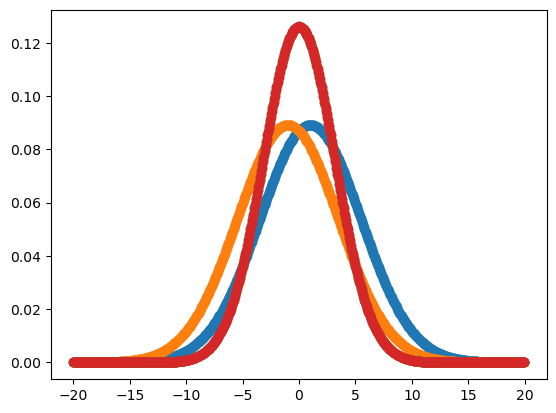

In [207]:
from functools import partial
heat_kernel_a = partial(heat_kernel,y=1,t=10)
heat_kernel_b = partial(heat_kernel,y=-1,t=10)
heat_kernel_center = partial(heat_kernel,y=0,t=5)
ys_a = np.array(list(map(heat_kernel_a,coords_1d)))
ys_b = np.array(list(map(heat_kernel_b,coords_1d)))
ys_c = list(map(heat_kernel_center,coords_1d))
ys_prod = (ys_a*ys_b)
ys_prod = ys_prod / riemann_integral(coords_1d,ys_prod)
plt.scatter(coords_1d,ys_a)
plt.scatter(coords_1d,ys_b)
plt.scatter(coords_1d,ys_prod)
plt.scatter(coords_1d,list(map(heat_kernel_center,coords_1d)))

You can't see the difference between the product and the distribution with half the time -- they are identical.

## Convolution of a heat diffusion with itself doubles the variance

In [208]:
def homemade_convolver(points):
    # Performs convolution of kernel with itself in 1d space
    results = np.zeros_like(points)
    heat_kernel_x = partial(heat_kernel,y=0,t=5)
    ys_x = np.array(list(map(heat_kernel_x,coords_1d)))
    for i in range(len(results)):
        heat_kernel_i = partial(heat_kernel,y=points[i],t=5)
        ys_i = np.array(list(map(heat_kernel_i,coords_1d)))
        results[i] += riemann_integral(points, ys_x*ys_i)
    results = results/(np.sum(results)*np.abs(points[0]-points[1]))
    return results

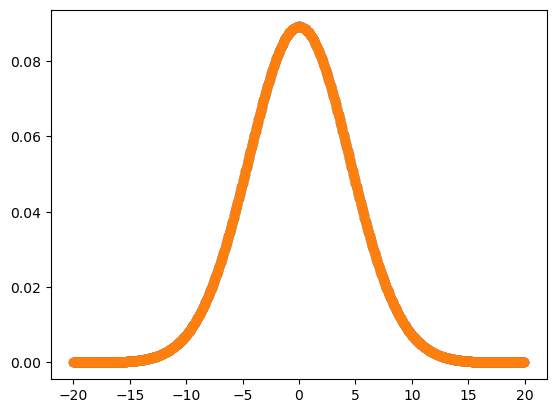

In [209]:
heat_kernel_center = partial(heat_kernel,y=0,t=10)
ys_convolved = homemade_convolver(coords_1d)
plt.scatter(coords_1d,ys_convolved)
ys_doubled = np.array(list(map(heat_kernel_center,coords_1d)))
plt.scatter(coords_1d,ys_doubled)

# Repeating with Diffusions

In [210]:
import altair as alt
import pandas as pd
df = pd.DataFrame({
    'x':coords_1d,
    'ys_convolved':ys_convolved,
    'ys_doubled':ys_doubled,
    'ys_a':ys_a,
    'ys_b':ys_b
})
alt.Chart(df).mark_line().encode(
    x = 'x',
    y = alt.Y(alt.repeat("layer"),aggregate="sum",title="y"),
    color = alt.datum(alt.repeat("layer")),
    ).repeat(layer=["ys_convolved","ys_doubled","ys_a","ys_b"])

alt.RepeatChart(...)

In [211]:
from diffusion_curvature.core import diffusion_matrix
coords_1d = np.arange(-20,20,0.05)
def diffusion_heat_kernel(points, y = 0, t = 5, alpha = 1):
    P = diffusion_matrix(points, kernel_type="adaptive anisotropic", alpha = alpha)
    Pt = np.linalg.matrix_power(P, t)
    return Pt[y]

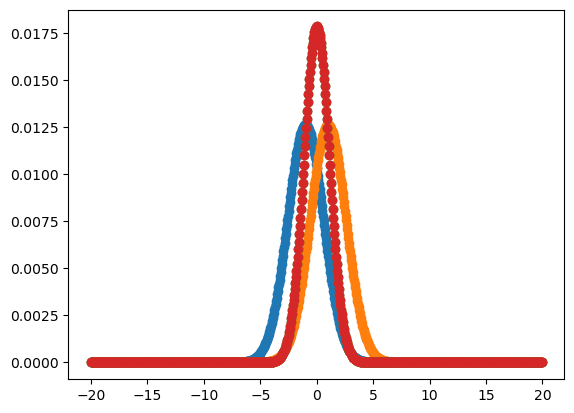

In [212]:
# testing the multiplication method
middle_y_index = len(coords_1d)//2
offset = 20
ys_a = diffusion_heat_kernel(coords_1d[:,None], y = middle_y_index - offset, alpha = 1, t = 10)
ys_b = diffusion_heat_kernel(coords_1d[:,None], y = middle_y_index + offset, alpha = 1, t = 10)
ys_mixed = ys_a * ys_b
ys_mixed /= np.sum(ys_mixed) # renormalize to sum to one
ys_center = diffusion_heat_kernel(coords_1d[:,None], y = middle_y_index, alpha = 1, t = 5)
# plot
plt.scatter(coords_1d,ys_a)
plt.scatter(coords_1d,ys_b)
plt.scatter(coords_1d,ys_center)
plt.scatter(coords_1d, ys_mixed)

It's as clear as day. It works.

How about in 2d?

In [213]:
coords_2d = np.random.rand(5000,2)*2-1
coords_2d = np.vstack([np.zeros(2),np.array([0,0.2]),np.array([0,-0.2]),np.zeros(2),coords_2d])
t = 10
ys_a = diffusion_heat_kernel(coords_2d, y = 1, alpha = 1, t = t)
ys_b = diffusion_heat_kernel(coords_2d, y = 2, alpha = 1, t = t)
ys_mixed = ys_a * ys_b
ys_mixed /= np.sum(ys_mixed) # renormalize to sum to one
ys_center = diffusion_heat_kernel(coords_2d, y = 0, alpha = 1, t = t//2)
# plot, now in 3d
def plot_diffusion_as_3d(points,signal):
    combined_points = np.hstack([points,signal[:,None]])
    plot_3d(combined_points,signal,lim=1,zlim=0.1)
combined_signal = ys_a + ys_b
plot_diffusion_as_3d(coords_2d,combined_signal)

TypeError: plot_3d() got an unexpected keyword argument 'zlim'

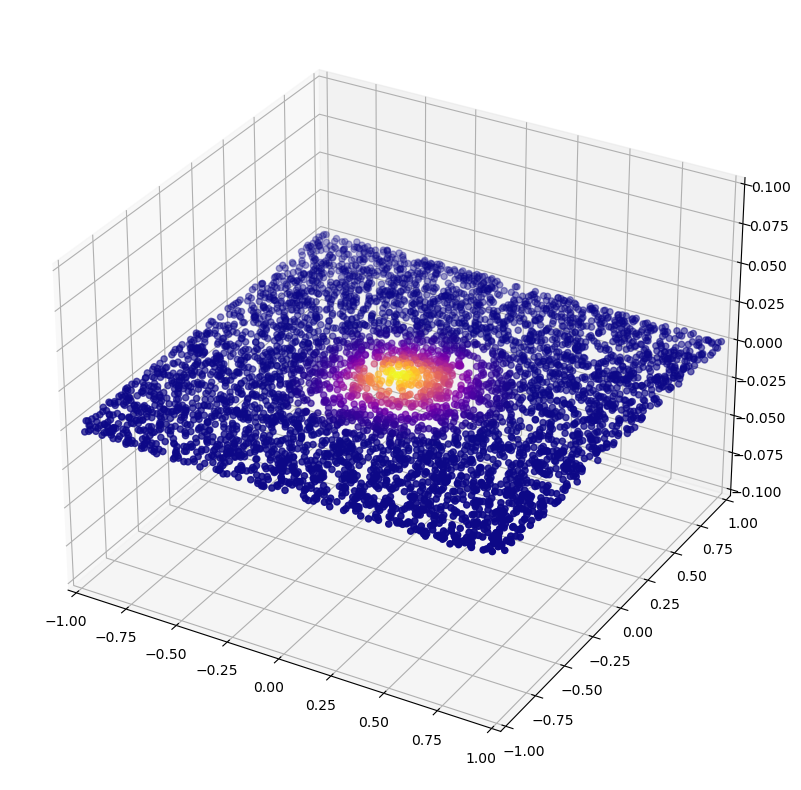

In [ ]:
plot_diffusion_as_3d(coords_2d,ys_mixed)

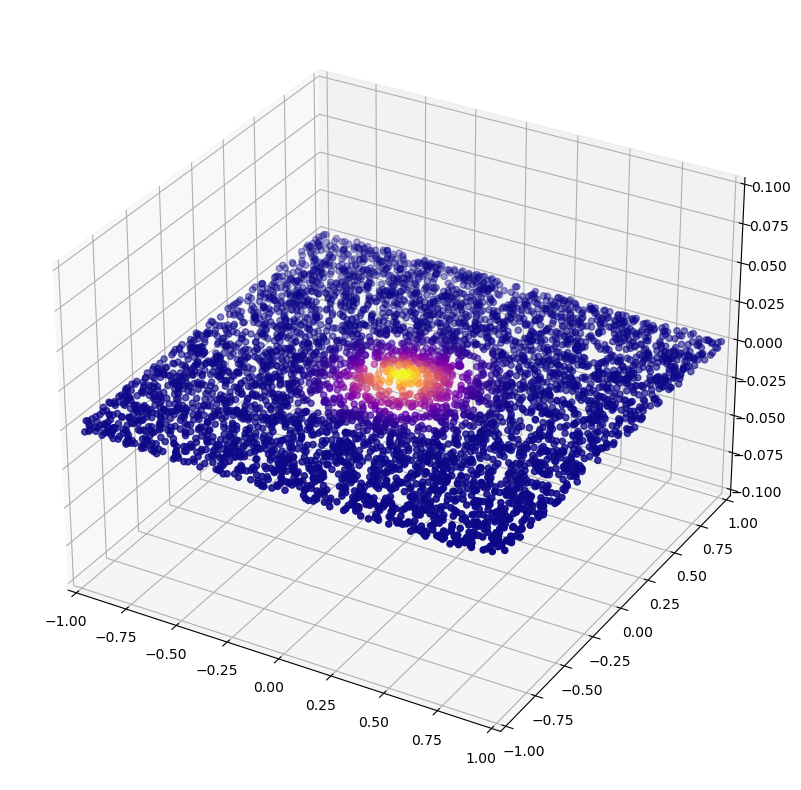

In [ ]:
plot_diffusion_as_3d(coords_2d,ys_center)

There is some difference here, but *very* small.

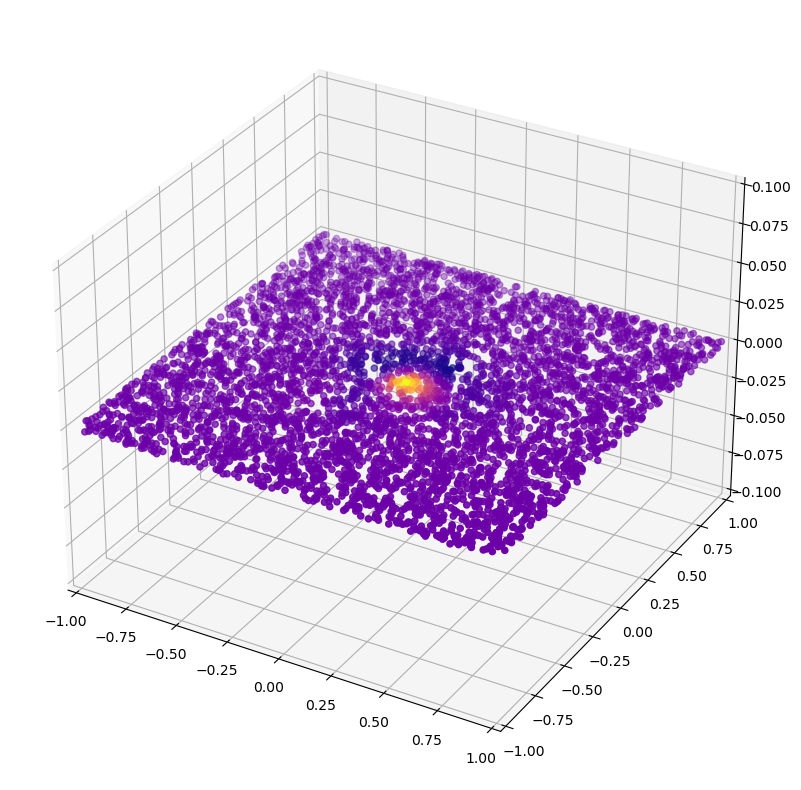

In [ ]:
plot_diffusion_as_3d(coords_2d,ys_center-ys_mixed)

In [ ]:
diff = ys_mixed - ys_center

In [ ]:
min(diff)

-0.0010899111112342968

In [ ]:
max(diff)

0.0002785768754849237

In [ ]:
np.sum(diff)

2.40692882291782e-16

## Testing on the sphere

In [283]:
from diffusion_curvature.datasets import sphere

In [284]:
X, ks_real = sphere(2000)
# add three points to the sphere: two opposing points, and a midpoint on the very top
X = np.vstack([
    np.array([0,0,1]),
    np.array([0.5,0.5,1])/np.sqrt(3),
    np.array([-0.5,-0.5,1])/np.sqrt(3),
    X
])

In [285]:
t = 6
ys_a = diffusion_heat_kernel(X, y = 1, alpha = 1, t = t)
ys_b = diffusion_heat_kernel(X, y = 2, alpha = 1, t = t)
ys_mixed = ys_a * ys_b
ys_mixed /= np.sum(ys_mixed) # renormalize to sum to one
ys_center = diffusion_heat_kernel(X, y = 0, alpha = 1, t = t//2)
# plot, now in 3d
combined_signal = ys_a + ys_b

In [286]:
plot_3d(X,combined_signal,use_plotly=True)

In [287]:
plot_3d(X,ys_mixed,use_plotly=True)

This reveals that, indeed, the product distribution doesn't look anything like the halved distribution on the sphere.

In [288]:
plot_3d(X,ys_center,use_plotly=True)

In [289]:
plot_3d(X,ys_mixed - ys_center,use_plotly=True)

The mixed distribution on this sphere is *less* concentrated around the center point than the center diffusion, and more concentrated pretty much everywhere else. It's as if the product diffusion is a higher power of diffusion than t/2.

In [290]:
np.sum(ys_mixed - ys_center)

1.8735013540549517e-16

In [291]:
np.sum((ys_mixed > ys_center).astype(int))

1879

In [292]:
((ys_center > ys_mixed).astype(int)*(ys_center)).sum()

0.6795542385016908

In [293]:
ys_center[0] - ys_mixed[0]

0.00401353836512872

So it's still very small -- but it is 10 times larger than previous, and is also *positive*, which is a good sign.

## Testing on the hyperboloid

In [318]:
from diffusion_curvature.datasets import hyperboloid

In [319]:
X, ks_real = hyperboloid(n=3000)

In [320]:
X = np.vstack(
    [
    np.array([[ 1.72486927,  1.09872855, -0.21352893],
        [ 0.25069893,  1.99813959,  0.11769852],
        [ 1.74178747, -0.99868253, -0.08830403]]),
    X
    ]
)

In [321]:
t = 6
ys_a = diffusion_heat_kernel(X, y = 1, alpha = 1, t = t)
ys_b = diffusion_heat_kernel(X, y = 2, alpha = 1, t = t)
ys_mixed = ys_a * ys_b
ys_mixed /= np.sum(ys_mixed) # renormalize to sum to one
ys_center = diffusion_heat_kernel(X, y = 0, alpha = 1, t = t//2)
# plot, now in 3d
combined_signal = ys_a + ys_b

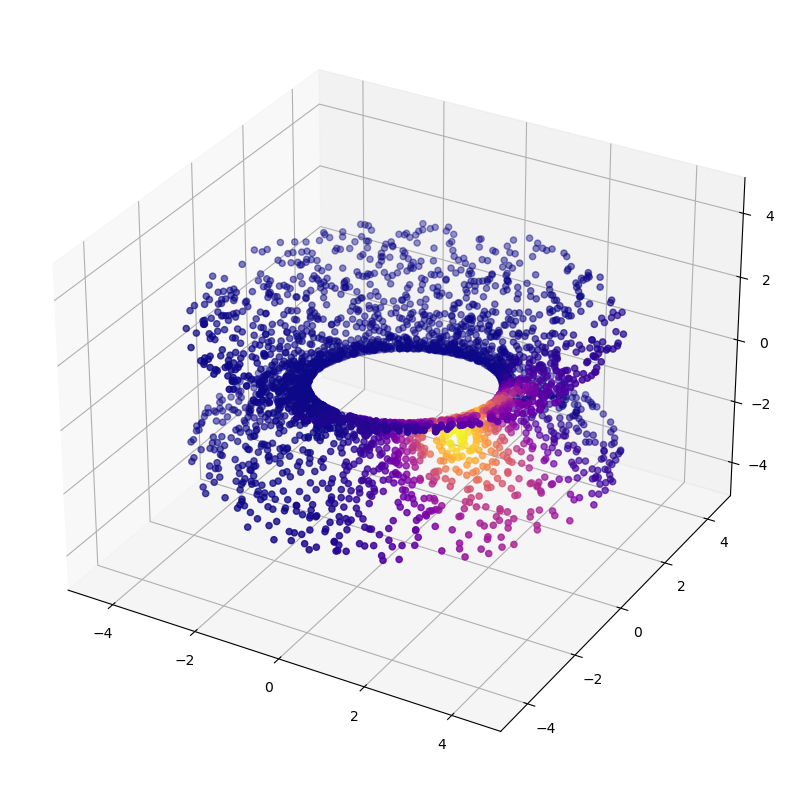

In [322]:
plot_3d(X,ys_b)

In [323]:
plot_3d(X,combined_signal,use_plotly=True)

In [324]:
plot_3d(X,ys_mixed, use_plotly=True)

In [325]:
plot_3d(X,ys_center,use_plotly=True)

In [326]:
plot_3d(X,ys_mixed - ys_center,use_plotly=True)

There's a negative region at the center of the diffusion, revealing that the product distribution is less concentrated at the center -- and, as the higher colors around the center reveal, more concentrated around *the edges furthest from either starting point.*

In [327]:
np.sum(ys_mixed - ys_center)

3.7535079211448164e-16

Hmm, so this is also positive and larger than the difference between the signals on the sphere. Evidently, I need to reconsider my strategy.

In [328]:
((ys_center > ys_mixed).astype(int)*(ys_center)).sum()

0.6477091211423155

In [329]:
ys_center[0] - ys_mixed[0]

0.0023361363174031393